/localscratch/78235/ipykernel_526605/2035830665.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  xmin,ymin,xmax,ymax = all_poly_4326.unary_union.bounds
/localscratch/78235/ipykernel_526605/2035830665.py:52: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  c = all_poly_4326.unary_union.centroid


Saved: ./figures/bathymetry_bvr.png


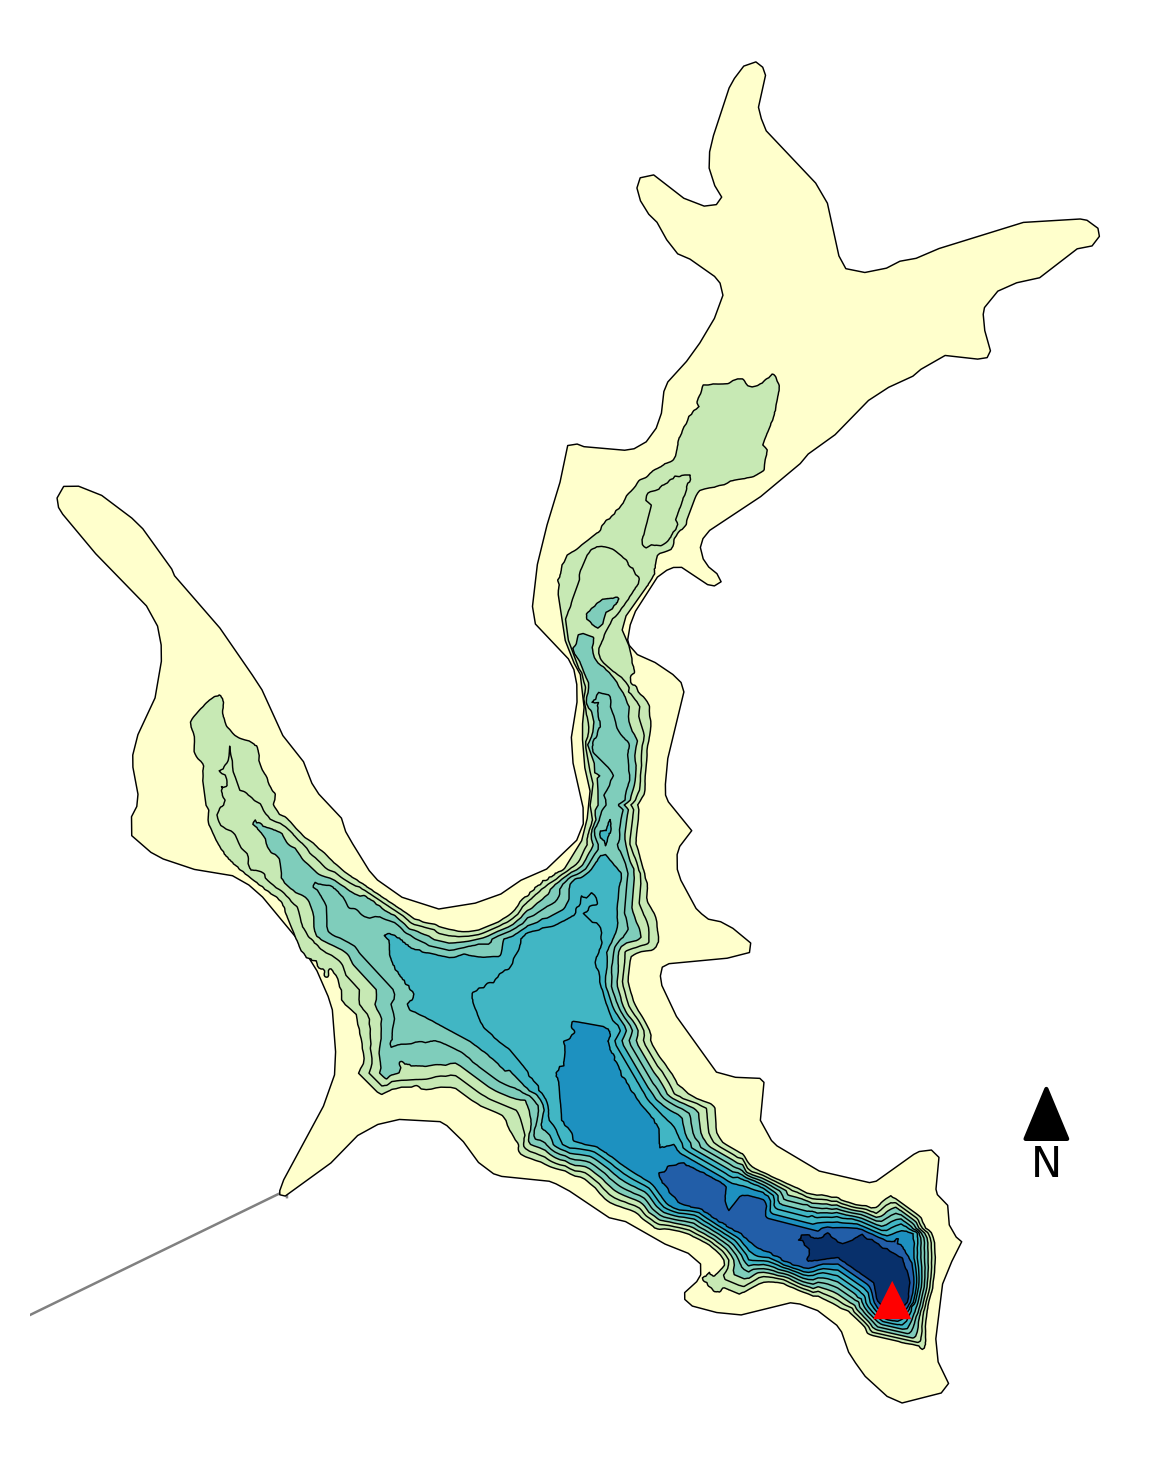

In [2]:
import os
import pandas as pd, geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1) Read shapefiles 
layer1  = gpd.read_file("0_2mpoly12apr18.shp")   # 0–2 m
layer2  = gpd.read_file("3mpoly_project.shp")    # 2–4 m (part)
layer3  = gpd.read_file("4mpoly_project.shp")    # 2–4 m (part)
layer4  = gpd.read_file("5mpoly_project.shp")    # 4–6 m (part)
layer5  = gpd.read_file("6mpoly_project.shp")    # 4–6 m (part)
layer6  = gpd.read_file("7mpoly_project.shp")    # 6–8 m (part)
layer7  = gpd.read_file("8mpoly_project.shp")    # 6–8 m (part)
layer8  = gpd.read_file("9mpoly_project.shp")    # 8–10 m
layer9  = gpd.read_file("10mpoly_project.shp")   # 10–12 m
layer10 = gpd.read_file("11mpoly_project.shp")   # 12–13.5 m 
inf     = gpd.read_file("inflow pipe.shp")       # inflow line(s)

# 2) depth categories
cat1 = layer1.copy()  # 0–2
cat2 = gpd.GeoDataFrame(pd.concat([layer2, layer3], ignore_index=True), crs=layer2.crs)  # 2–4
cat3 = gpd.GeoDataFrame(pd.concat([layer4, layer5], ignore_index=True), crs=layer4.crs)  # 4–6
cat4 = gpd.GeoDataFrame(pd.concat([layer6, layer7], ignore_index=True), crs=layer6.crs)  # 6–8
cat5 = layer8.copy()   # 8–10
cat6 = layer9.copy()   # 10–12
cat7 = layer10.copy()  # 12–13.5 

for gdf, lab in [
    (cat1,"0-2 m"), (cat2,"2-4 m"), (cat3,"4-6 m"),
    (cat4,"6-8 m"), (cat5,"8-10 m"), (cat6,"10-12 m"),
    (cat7,"12-13.5 m"),
]:
    gdf["depth"] = lab

# 3) project
def to4326(x):
    if x.crs is None: return x.set_crs(4326, allow_override=True)
    return x if x.crs.to_epsg()==4326 else x.to_crs(4326)

cat1=to4326(cat1); cat2=to4326(cat2); cat3=to4326(cat3)
cat4=to4326(cat4); cat5=to4326(cat5); cat6=to4326(cat6); cat7=to4326(cat7)
inf =to4326(inf)

all_poly_4326 = gpd.GeoDataFrame(pd.concat([cat1,cat2,cat3,cat4,cat5,cat6,cat7], ignore_index=True), crs=4326)
xmin,ymin,xmax,ymax = all_poly_4326.unary_union.bounds
px,py = (xmax-xmin)*0.02,(ymax-ymin)*0.02
bbox_wgs = gpd.GeoDataFrame(geometry=[box(xmin-px,ymin-py,xmax+px,ymax+py)], crs=4326)


c = all_poly_4326.unary_union.centroid
zone = int((c.x+180)//6 + 1)
epsg_utm = 32600+zone if c.y>=0 else 32700+zone

cat1_u=cat1.to_crs(epsg_utm); cat2_u=cat2.to_crs(epsg_utm); cat3_u=cat3.to_crs(epsg_utm)
cat4_u=cat4.to_crs(epsg_utm); cat5_u=cat5.to_crs(epsg_utm); cat6_u=cat6.to_crs(epsg_utm); cat7_u=cat7.to_crs(epsg_utm)
inf_u =inf.to_crs(epsg_utm)
bxmin,bymin,bxmax,bymax = bbox_wgs.to_crs(epsg_utm).total_bounds


depth_palette = {
    "0-2 m":     "#FFFFCC",
    "2-4 m":     "#C7E9B4",
    "4-6 m":     "#7FCDBB",
    "6-8 m":     "#41B6C4",
    "8-10 m":    "#1D91C0",
    "10-12 m":   "#225EA8",
    "12-13.5 m": "#08306B",  # distinct darkest blue
}
edge_color="black"

# 5) Plot
fig, ax = plt.subplots(figsize=(7,5), dpi=300)
inf_u.plot(ax=ax, color="grey", linewidth=0.6, label="Tunnel Branch")

for gdf in [cat1_u,cat2_u,cat3_u,cat4_u,cat5_u,cat6_u,cat7_u]:
    lab=gdf["depth"].iloc[0]
    gdf.plot(ax=ax, facecolor=depth_palette[lab], edgecolor=edge_color, linewidth=0.35, zorder=5)

ax.set_xlim(bxmin,bxmax); ax.set_ylim(bymin,bymax)
ax.set_aspect('equal'); ax.set_axis_off()

# Star marker in figure 
ax.text(0.78, 0.10, "▲", transform=ax.transAxes, fontsize=12, color="red",
        ha="center", va="center", zorder=10)

# North arrow
def add_north_arrow(ax, location=(0.92,0.18), size=0.06):
    x0,x1=ax.get_xlim(); y0,y1=ax.get_ylim()
    xx=x0+(x1-x0)*location[0]; yy=y0+(y1-y0)*location[1]; dy=(y1-y0)*size
    ax.annotate('N', xy=(xx,yy+dy*1.15), xytext=(xx,yy),
                arrowprops=dict(facecolor='black', edgecolor='black', width=2, headwidth=10),
                ha='center', va='bottom', fontsize=10, color='black', zorder=9)

add_north_arrow(ax)

plt.tight_layout()
os.makedirs("./figures", exist_ok=True)
out_png = "./figures/bathymetry_bvr.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight")
print(f"Saved: {out_png}")
plt.show()

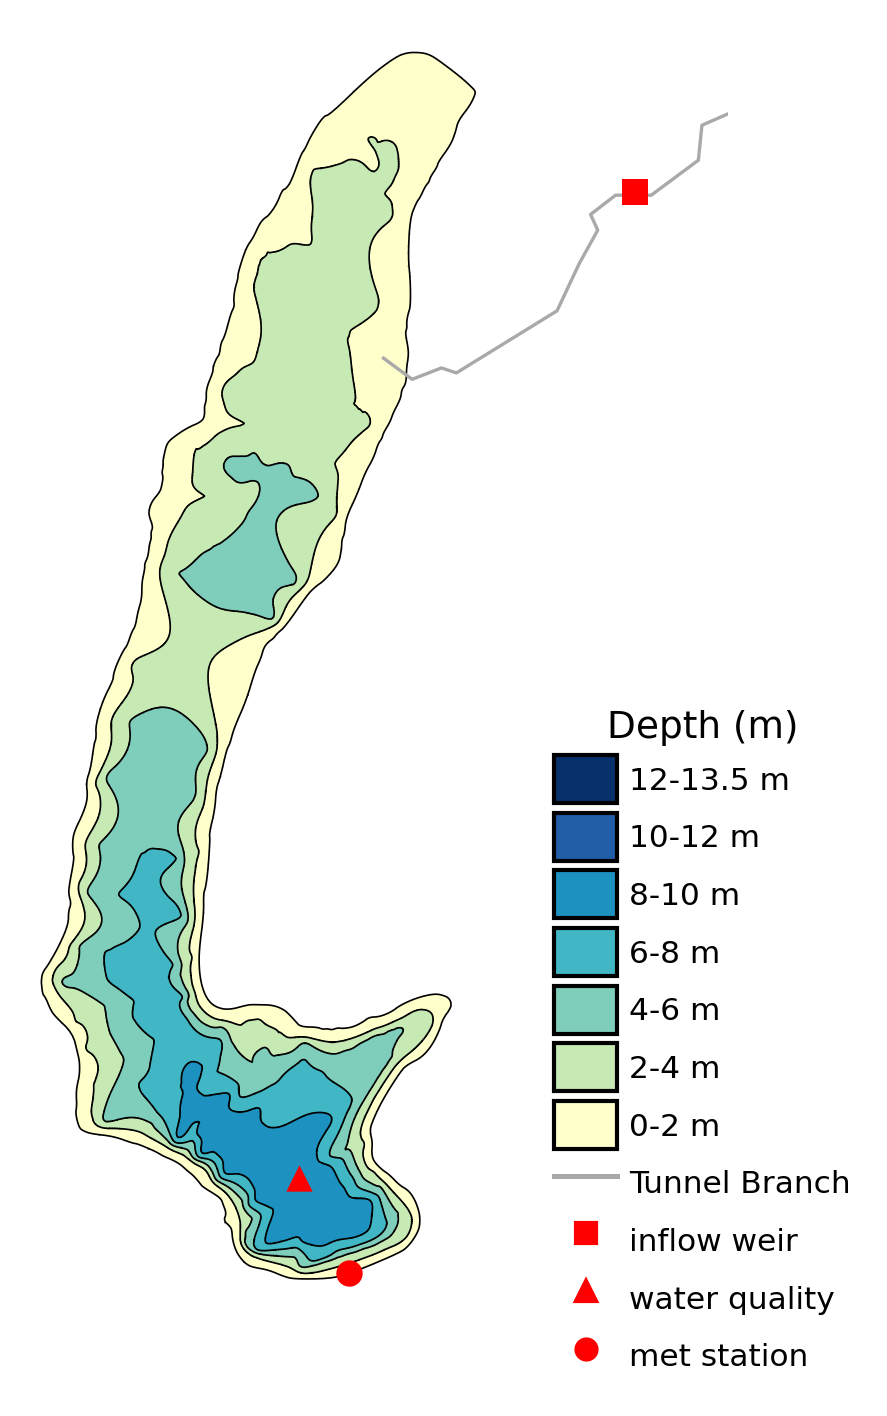

Saved: ./figures/bathymetry_fcr.png


In [3]:
import os
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ---------- 1) Read shapefiles ----------
layer1 = gpd.read_file("506_9.shp")   # 0–2 m
layer2 = gpd.read_file("504_9.shp")   # 2–4 m
layer3 = gpd.read_file("502_9.shp")   # 4–6 m
layer4 = gpd.read_file("500_9.shp")   # 6–8 m
layer5 = gpd.read_file("498_9.shp")   # 8–10 m
inf    = gpd.read_file("inf2.shp")    # inflow line(s)

# ---------- 2) depth ----------
layer1["depth"] = "0-2 m"
layer2["depth"] = "2-4 m"
layer3["depth"] = "4-6 m"
layer4["depth"] = "6-8 m"
layer5["depth"] = "8-10 m"

# ---------- 3) Sampling sites----------
sampling_sites = pd.DataFrame({
    "site_name": ["inflow weir","water quality","met station"],
    "x": [603243.949, 603042.080, 603072.080],
    "y": [4129741.320, 4129147.407, 4129090.407],
})
crs_use = layer1.crs  # assume all layers share CRS
sites_gdf = gpd.GeoDataFrame(
    sampling_sites,
    geometry=[Point(xy) for xy in zip(sampling_sites["x"], sampling_sites["y"])],
    crs=crs_use
)

# ---------- 4) Plot limits (projected units) ----------
xlim = (602880, 603300)
ylim = (4129077, 4129839)

# ---------- 5) Styles ----------
depth_palette = {
    "12-13.5 m": "#08306B",  
    "10-12 m": "#225EA8",
    "8-10 m":  "#1D91C0",
    "6-8 m":   "#41B6C4",
    "4-6 m":   "#7FCDBB",
    "2-4 m":   "#C7E9B4",
    "0-2 m":   "#FFFFCC",
}

edge_color = "black"

site_markers = {
    "inflow weir": ("s", 40),   # square
    "met station": ("o", 40),   # circle
    "water quality": ("^", 40), # triangle up
}

# ---------- 6) Helpers----------
def add_scalebar(ax, length_m=None, location=(0.86, 0.06), height_frac=0.01):
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    width = abs(x1 - x0)
    if length_m is None:
        target = width / 5
        p10 = 10 ** math.floor(math.log10(target))
        for n in (1, 2, 5):
            cand = n * p10
            if cand >= target:
                length_m = cand
                break
    L = length_m
    xx = x0 + (x1 - x0) * location[0]
    yy = y0 + (y1 - y0) * location[1]
    ax.add_patch(plt.Rectangle((xx, yy), L, (y1 - y0) * height_frac,
                               facecolor="grey", edgecolor="none", zorder=5))
    label = f"{int(L)} m" if L < 1000 else f"{L/1000:.0f} km"
    ax.text(xx + L/2, yy + (y1 - y0) * height_frac * 1.6, label,
            ha="center", va="bottom", fontsize=8, color="black", zorder=6)

def add_north_arrow(ax, location=(0.96, 0.18), size_frac=0.06):
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    xx = x0 + (x1 - x0) * location[0]
    yy = y0 + (y1 - y0) * location[1]
    dy = (y1 - y0) * size_frac
    ax.annotate('N', xy=(xx, yy + dy*1.15), xytext=(xx, yy),
                arrowprops=dict(facecolor='grey', edgecolor='grey', width=2, headwidth=10),
                ha='center', va='bottom', fontsize=10, color='black', zorder=6)

# ---------- 7) Plot ----------
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

# Inflow line
inf.plot(ax=ax, color="darkgray", linewidth=0.8, label="Tunnel Branch", zorder=3)


for gdf in [layer1, layer2, layer3, layer4, layer5]:
    depth = gdf["depth"].iloc[0]
    gdf.plot(ax=ax,
             facecolor=depth_palette[depth],
             edgecolor=edge_color,
             linewidth=0.4,
             zorder=2)

# Sampling sites
for name, (marker, size) in site_markers.items():
    sel = sites_gdf[sites_gdf["site_name"] == name]
    ax.scatter(sel.geometry.x, sel.geometry.y,
               s=size, marker=marker, c="red",
               linewidths=0.0, label=name, zorder=8)


ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.set_aspect('equal')
#ax.set_xlabel(""); ax.set_ylabel("")
#ax.tick_params(axis='x', labelrotation=45)
#ax.spines[['top','right','left','bottom']] = [False, False, False, False]


ax.set_axis_off()                 
fig.patch.set_facecolor("white")  
ax.set_facecolor("white")        


# Legend 
handles = [
    Patch(facecolor=depth_palette["12-13.5 m"], edgecolor=edge_color, label="12-13.5 m"),
    Patch(facecolor=depth_palette["10-12 m"], edgecolor=edge_color, label="10-12 m"),
    Patch(facecolor=depth_palette["8-10 m"],  edgecolor=edge_color, label="8-10 m"),
    Patch(facecolor=depth_palette["6-8 m"],   edgecolor=edge_color, label="6-8 m"),
    Patch(facecolor=depth_palette["4-6 m"],   edgecolor=edge_color, label="4-6 m"),
    Patch(facecolor=depth_palette["2-4 m"],   edgecolor=edge_color, label="2-4 m"),
    Patch(facecolor=depth_palette["0-2 m"],   edgecolor=edge_color, label="0-2 m"),
    Line2D([0],[0], color="darkgray", lw=1.2, label="Tunnel Branch"),
    Line2D([0],[0], marker='s', color='red', markerfacecolor='red', lw=0, label="inflow weir"),
    Line2D([0],[0], marker='^', color='red', markerfacecolor='red', lw=0, label="water quality"),
    Line2D([0],[0], marker='o', color='red', markerfacecolor='red', lw=0, label="met station"),

]

leg = ax.legend(
    handles=handles,
    loc="upper left",                      # anchor corner of the legend
    bbox_to_anchor=(0.72, 0.48),          # x,y in axes fraction [0..1]
    bbox_transform=ax.transAxes,          # interpret as axes coords
    frameon=True, framealpha=0.9,         # readable box
    facecolor="white", edgecolor="none",
    fontsize=7.5, title="Depth (m)", title_fontsize=9,
    handlelength=2.0, handleheight=2.0, handletextpad=0.4,
    borderpad=0.2, labelspacing=0.3, markerscale=0.8
)

plt.tight_layout()

# ---------- 8) Show and save ----------
os.makedirs("./figures", exist_ok=True)
out_png = "./figures/bathymetry_fcr.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")